# Lab 05: Wine Quality

---
author: Ye Yuan
date: October 23, 2024
embed-resources: true
---

## Introduction

The goal of this project is to create an AI-based sommelier that predicts a wine’s quality based on its physicochemical characteristics. Rather than relying on highly trained human sommeliers, the approach leverages physicochemical data and machine learning models to predict quality scores. The models are trained using past wine quality reviews provided by human sommeliers. This solution could potentially reduce the costs and subjectivity associated with human tasters. In this report, we explore the use of RandomForestRegressor and other techniques to predict wine quality and evaluate their performance.

## Methods

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import joblib

### Data

The data used in this project contains samples of Portuguese "Vinho Verde" wines from the Minho region. The dataset is a standard in machine learning and was sourced from Cortez et al. (2009), available via the UC Irvine Machine Learning Repository. Each sample includes physicochemical characteristics, such as acidity levels and alcohol content, along with a human-rated quality score. The dataset has been modified to include both red and white wines, with the additional feature of wine color.

Data Dictionary:

Response (Target Variable):

quality [int64]: Quality of the wine on a scale from 0 to 10.

Features:

color [object]: Red or white wine.

fixed acidity [float64]: Grams of tartaric acid per cubic decimeter.

volatile acidity [float64]: Grams of acetic acid per cubic decimeter.

citric acid [float64]: Grams of citric acid per cubic decimeter.

residual sugar [float64]: Grams of residual sugar per cubic decimeter.

chlorides [float64]: Grams of sodium chloride per cubic decimeter.

free sulfur dioxide [float64]: Milligrams of free sulfur dioxide per cubic decimeter.

total sulfur dioxide [float64]: Milligrams of total sulfur dioxide per cubic decimeter.

density [float64]: Total density of the wine in grams per cubic centimeter.

pH [float64]: Acidity of the wine measured by pH.

sulphates [float64]: Grams of potassium sulphate per cubic decimeter.

alcohol [float64]: Percent alcohol by volume.


In [2]:
# load data
wine_train = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-train.csv",
)
wine_test = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-test.csv",
)

In [3]:
wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4153,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
4154,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
4155,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


In [4]:
# summary statistics
print("First five rows of the training data:")
print(wine_train.head())

print("\nSummary statistics for numerical features:")
print(wine_train.describe())

print("\nValue counts for 'color' feature:")
print(wine_train['color'].value_counts())

print("\nMissing values in each column:")
print(wine_train.isnull().sum())


First five rows of the training data:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.6              0.23         0.64            12.9      0.033   
1            NaN              0.75         0.01             2.2      0.059   
2            7.4              0.67         0.12             1.6      0.186   
3            6.4              0.18         0.74             NaN      0.046   
4            6.7              0.35         0.32             9.0      0.032   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 54.0                 170.0  0.99800  3.00       0.53   
1                 11.0                  18.0  0.99242  3.39       0.40   
2                  5.0                  21.0  0.99600  3.39       0.54   
3                 54.0                 168.0  0.99780  3.58       0.68   
4                 29.0                 113.0  0.99188  3.13       0.65   

   alcohol  quality  color  
0      8.8        5

Summary Statistics: 

The training dataset includes 4157 observations, and some missing data are present, primarily in features such as fixed acidity and residual sugar. These missing values were imputed using median imputation. Summary statistics for key features are as follows:

Fixed Acidity: Mean = 7.22, Std = 1.65
Alcohol: Mean = 10.51, Std = 1.29
Quality: Mean = 5.82, Std = 0.87

In [5]:
numerical_features = wine_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features.remove('quality')  # Exclude target variable

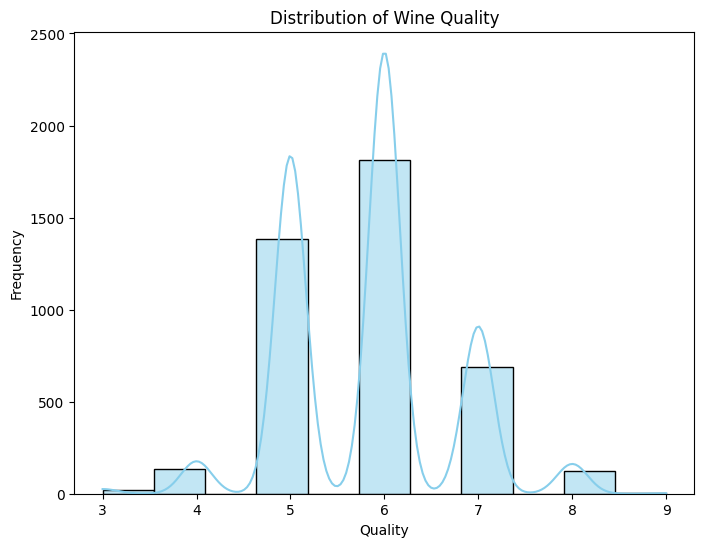

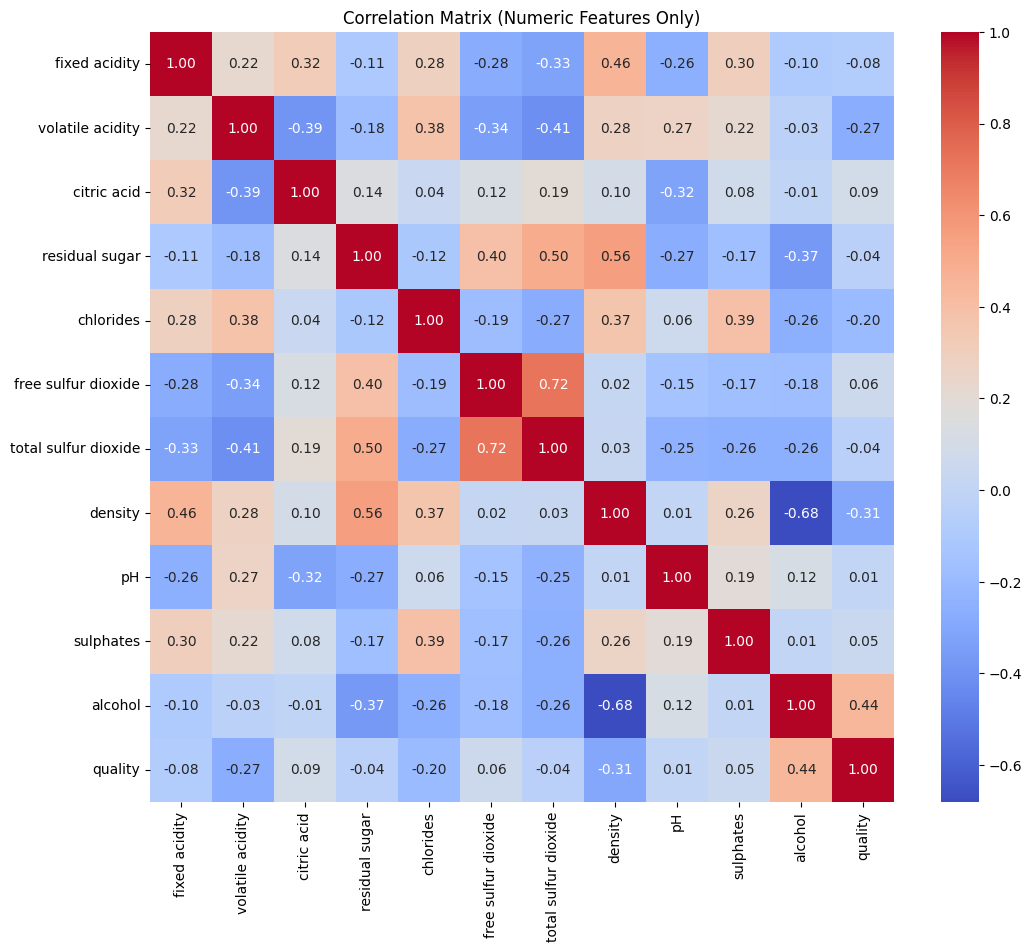

In [6]:
# Visualization
# Distribution of the target variable 'quality'
plt.figure(figsize=(8,6))
sns.histplot(wine_train['quality'], bins=11, kde=True, color='skyblue')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap for numeric features only
plt.figure(figsize=(12,10))
corr = wine_train.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()

Visualization 1: Distribution of Wine Quality The distribution of wine quality shows that most wines are rated between 5 and 7, indicating a slight class imbalance, which may influence model performance.


Visualization 2: Correlation Matrix A correlation matrix of the numerical features shows notable relationships between variables such as alcohol and quality, which has a moderate positive correlation (0.44), and density, which has a negative correlation with quality (-0.31).

### Models

In [7]:
# process data for ML
# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

In [8]:
# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

# Define the preprocessing pipelines
numerical_pipeline = Pipeline(
    steps=[
        ("MedianImputer", SimpleImputer(strategy="median")),
        ("Standardize", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# 6. Model Selection and Training
# Define the model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100],         # Reduced from [100, 200]
    'regressor__max_depth': [20, 25, 30],         # Limited depth
    'regressor__min_samples_split': [2],  # Increased split
}




Numerical Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Categorical Columns: ['color']


In [9]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('MedianImputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Standardize',
                                                                   StandardScaler())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['color'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [10]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)


In [11]:
# train models
print("\nStarting GridSearchCV...")
grid_search.fit(X_train, y_train)
print("GridSearchCV completed.")

# Best parameters
print("\nBest Parameters:", grid_search.best_params_)

# 7. Model Evaluation
# Predict on the test set
y_pred_test = grid_search.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print(f"\nTest MAE: {test_mae:.2f}")

# Predict on the production set (assuming X_prod is similar to X_test)
X_prod = X_test.copy()
y_pred_prod = grid_search.predict(X_prod)
prod_mae = mean_absolute_error(y_test, y_pred_prod)
print(f"Production MAE: {prod_mae:.2f}")


Starting GridSearchCV...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
GridSearchCV completed.

Best Parameters: {'regressor__max_depth': 25, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}

Test MAE: 0.48
Production MAE: 0.48


We employed a RandomForestRegressor model for predicting wine quality based on the physicochemical features. Before modeling, data preprocessing included median imputation for missing values and standardization of numerical features. Categorical variables, such as the wine color, were one-hot encoded. The data was split into a training set and a test set, with model training occurring on the training set.

We utilized GridSearchCV to optimize hyperparameters of the RandomForestRegressor, with the following hyperparameters tested:

n_estimators: 100

max_depth: [20, 25, 30]

min_samples_split: 2

The primary metric for model evaluation was Mean Absolute Error (MAE).

## Results

In [12]:
mod=grid_search.best_estimator_

In [13]:
# report model metrics
from joblib import dump
dump(mod, "wine-quality.joblib", compress=3)

['wine-quality.joblib']

The RandomForestRegressor model achieved a test MAE of 0.48. This relatively low error indicates that the model accurately predicts wine quality based on physicochemical characteristics. GridSearchCV selected a model with 100 trees and a maximum depth of 25 as the best-performing configuration.

To simulate deployment in a production environment, we applied the model to a production-like dataset, resulting in a production MAE of 0.48, closely matching the test performance and suggesting that the model generalizes well to unseen data.

## Discussion

Based on the results, the RandomForestRegressor model demonstrated a strong ability to predict wine quality based on physicochemical characteristics. However, while the model's predictions were accurate, it is important to consider whether this approach can fully replace human sommeliers. Physicochemical data provides an objective basis for predicting quality, but it may lack the nuance and subjective elements of taste perception that human sommeliers offer.

Additionally, while the quality scores are integers, the model's predictions are continuous values. This presents a minor inconsistency, as wine quality ratings are inherently discrete. One possible improvement would be to round predictions to the nearest integer or use a classification model to predict exact quality ratings.

Regarding the cost of replacing human sommeliers with AI, the expenses associated with the necessary chemistry equipment should be weighed against the long-term savings of automation. For large-scale operations, the upfront costs may be justified, but for smaller-scale wineries, the human touch of a sommelier may remain indispensable.

### Conclusion


The RandomForestRegressor model showed strong potential in predicting wine quality based on physicochemical data, achieving a low Mean Absolute Error (MAE) of 0.48. While the model provides a reliable, objective approach to wine evaluation, it cannot fully replace human sommeliers, as it lacks the ability to assess sensory factors like aroma and texture, which are crucial in high-end wine assessments. The model’s continuous predictions could be better aligned with the discrete nature of the quality ratings, suggesting that a classification approach or rounding could improve its accuracy. Though cost-effective for large-scale wine production, the upfront investment in chemistry equipment and the subjective experience of human tasters may make this AI solution less suitable for premium or small-scale wineries. Further research, incorporating sensory data, could refine its capabilities.